# Building My First Neural Network  
**APCV 485 | Week 1–2 Coding Assignment**  
*Brian Stever (24042080)*

This notebook builds a simple feedforward neural network for binary classification, following the assignment specs. I use Keras/TensorFlow to create, train, and evaluate the model on synthetic data. I’m using Keras/TensorFlow here because it’s great for rapid prototyping and getting a full end-to-end workflow working quickly. I’m looking forward to digging into PyTorch later for more academic and research-oriented projects.

## Setup

Importing the required libraries and setting seeds for reproducibility.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

TensorFlow version: 2.20.0
NumPy version: 2.4.1


## Task 1: Data Preparation

Creating a synthetic dataset with 1000 samples and 10 features. Labels are based on a weighted sum of the first 5 features so the network has a real pattern to learn. Using stratify in the split keeps class balance consistent.

In [2]:
def generate_dataset(n_samples=1000):
    """Generate a synthetic dataset for binary classification."""
    
    # Generate random features
    X = np.random.rand(n_samples, 10)
    
    # Generate labels based on weighted sum of first 5 features
    weighted_sum = (0.3 * X[:, 0] + 
                    0.3 * X[:, 1] + 
                    0.2 * X[:, 2] + 
                    0.1 * X[:, 3] + 
                    0.1 * X[:, 4])
    
    # Adding noise to make it more realistic
    noise = np.random.normal(0, 0.05, n_samples)
    
    # If weighted sum + noise > 0.5, label is 1, otherwise 0
    y = (weighted_sum + noise > 0.5).astype(int)
    
    return X, y

# Generate the dataset
X, y = generate_dataset(n_samples=1000)

print(f"Dataset generated!")
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Dataset generated!
Features shape: (1000, 10)
Labels shape: (1000,)


In [3]:
# 80/20 split, stratify keeps class balance in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (800, 10)
Test set: (200, 10)


In [4]:
# Check class balance
print("Class distribution:")
print("-" * 30)

for name, data in [("Full dataset", y), ("Training", y_train), ("Test", y_test)]:
    unique, counts = np.unique(data, return_counts=True)
    print(f"\n{name}:")
    for cls, count in zip(unique, counts):
        print(f"  Class {cls}: {count} ({count/len(data)*100:.1f}%)")

Class distribution:
------------------------------

Full dataset:
  Class 0: 530 (53.0%)
  Class 1: 470 (47.0%)

Training:
  Class 0: 424 (53.0%)
  Class 1: 376 (47.0%)

Test:
  Class 0: 106 (53.0%)
  Class 1: 94 (47.0%)


In [5]:
# Quick check - features should be between 0 and 1
print(f"Feature range: [{X.min():.4f}, {X.max():.4f}]")
print(f"Mean: {X.mean():.4f}")

Feature range: [0.0000, 0.9997]
Mean: 0.4942


## Task 2: Build the Network

Architecture: 10 inputs, 16 neurons (ReLU), 8 neurons (ReLU), 1 output (Sigmoid).

ReLU adds non-linearity so the layers don't just collapse into one linear transformation. Sigmoid at the end gives us a probability between 0 and 1 for the binary classification.

In [6]:
def build_model():
    """Build a feedforward neural network for binary classification."""
    
    model = keras.Sequential([

        # Moved input shape outside of first Dense layer to fix warning based on updated documentation/Keras version
        keras.Input(shape=(10,)),

        # First hidden layer - 16 neurons, ReLU
        keras.layers.Dense(16, activation='relu'),
        
        # Second hidden layer - 8 neurons
        keras.layers.Dense(8, activation='relu'),
        
        # Output layer - sigmoid for probability
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

## Task 3: Compile

Using Adam optimizer with lr=0.001 and binary cross-entropy loss since this is a binary classification problem.

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model compiled!")

Model compiled!


## Task 4: Train

Training for 50 epochs with batch size 32 and 20% validation split. The validation set helps catch overfitting if the val_loss starts going up while training loss keeps dropping.

In [8]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4875 - loss: 0.6910 - val_accuracy: 0.5063 - val_loss: 0.6880
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5562 - loss: 0.6828 - val_accuracy: 0.6062 - val_loss: 0.6811
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6062 - loss: 0.6766 - val_accuracy: 0.6062 - val_loss: 0.6744
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6187 - loss: 0.6705 - val_accuracy: 0.6187 - val_loss: 0.6664
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.6630 - val_accuracy: 0.6687 - val_loss: 0.6570
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6531 - loss: 0.6536 - val_accuracy: 0.6687 - val_loss: 0.6454
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6766 - loss: 0.6412 - val_accuracy: 0.6938 - val_loss: 0.6265
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6984 - loss: 0.6242 - val_accuracy: 0.7312 - val_loss:

## Task 5: Evaluate

Testing on the held-out test data to see how well the model generalizes.

In [9]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 0.2577
Test Accuracy: 89.50%


In [10]:
# Get predictions and convert to class labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.92      0.90       106
     Class 1       0.91      0.86      0.89        94

    accuracy                           0.90       200
   macro avg       0.90      0.89      0.89       200
weighted avg       0.90      0.90      0.89       200



In [11]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print(f"\nTN: {cm[0,0]} | FP: {cm[0,1]}")
print(f"FN: {cm[1,0]} | TP: {cm[1,1]}")

Confusion Matrix:
[[98  8]
 [13 81]]

TN: 98 | FP: 8
FN: 13 | TP: 81


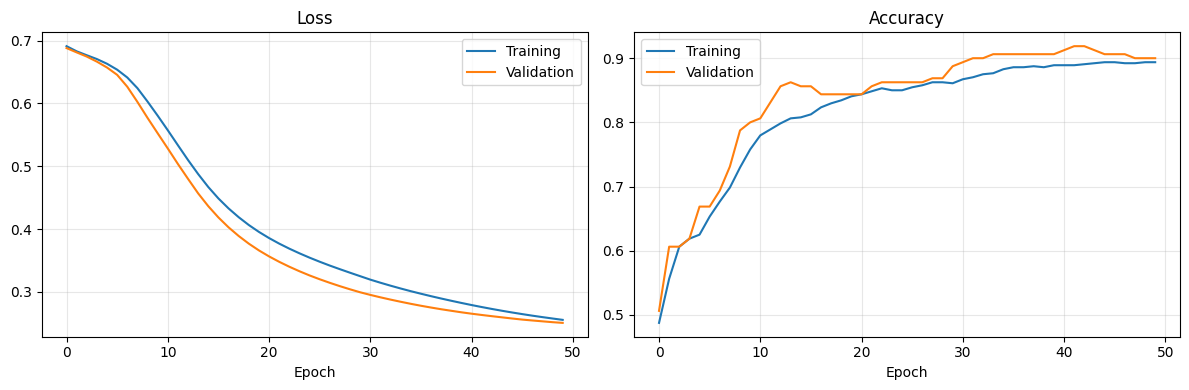

In [12]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss over time
ax1.plot(history.history['loss'], label='Training')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy over time
ax2.plot(history.history['accuracy'], label='Training')
ax2.plot(history.history['val_accuracy'], label='Validation')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Training and validation curves track pretty closely so no major overfitting. Both losses go down smoothly which means it's learning the pattern.

## Bonus: Analysis Questions

Testing how different settings affect the model.

### Experiment 1: What if we remove activation functions?

Without ReLU activations, the network should basically become a linear model since stacking linear layers just gives you one big linear transformation.

In [13]:
# Same architecture but with no activation in hidden layers
def build_model_no_activation():
    model = keras.Sequential([
        keras.Input(shape=(10,)),
        keras.layers.Dense(16, activation=None),  # No ReLU
        keras.layers.Dense(8, activation=None),                       # No ReLU
        keras.layers.Dense(1, activation='sigmoid')  # Still need this for output
    ])
    return model

model_no_act = build_model_no_activation()
model_no_act.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Training without activations...")
history_no_act = model_no_act.fit(X_train, y_train, epochs=50, batch_size=32, 
                                   validation_split=0.2, verbose=0)

test_loss_no_act, test_acc_no_act = model_no_act.evaluate(X_test, y_test, verbose=0)

print(f"\nWithout activations: {test_acc_no_act*100:.2f}%")
print(f"With activations:    {test_accuracy*100:.2f}%")

Training without activations...

Without activations: 90.00%
With activations:    89.50%


Results are similar because this dataset has a mostly linear decision boundary (weighted sum > threshold). For complex non-linear patterns, removing activations would hurt way more.

### Experiment 2: How does learning rate affect training?

Learning rate controls how big of steps the optimizer takes. Too small and it's slow, too big and it might overshoot. Testing 0.0001, 0.001, and 0.01.

In [14]:
learning_rates = [0.0001, 0.001, 0.01]
histories = {}
results = {}

for lr in learning_rates:
    print(f"Training with lr={lr}...", end=" ")
    
    model_lr = build_model()
    model_lr.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    history_lr = model_lr.fit(X_train, y_train, epochs=50, batch_size=32,
                              validation_split=0.2, verbose=0)
    
    _, test_acc_lr = model_lr.evaluate(X_test, y_test, verbose=0)
    histories[lr] = history_lr
    results[lr] = test_acc_lr
    
    print(f"Accuracy: {test_acc_lr*100:.2f}%")

print("\nSummary:")
for lr, acc in results.items():
    print(f"  lr={lr}: {acc*100:.2f}%")

Training with lr=0.0001... Accuracy: 77.00%
Training with lr=0.001... Accuracy: 88.00%
Training with lr=0.01... Accuracy: 82.50%

Summary:
  lr=0.0001: 77.00%
  lr=0.001: 88.00%
  lr=0.01: 82.50%


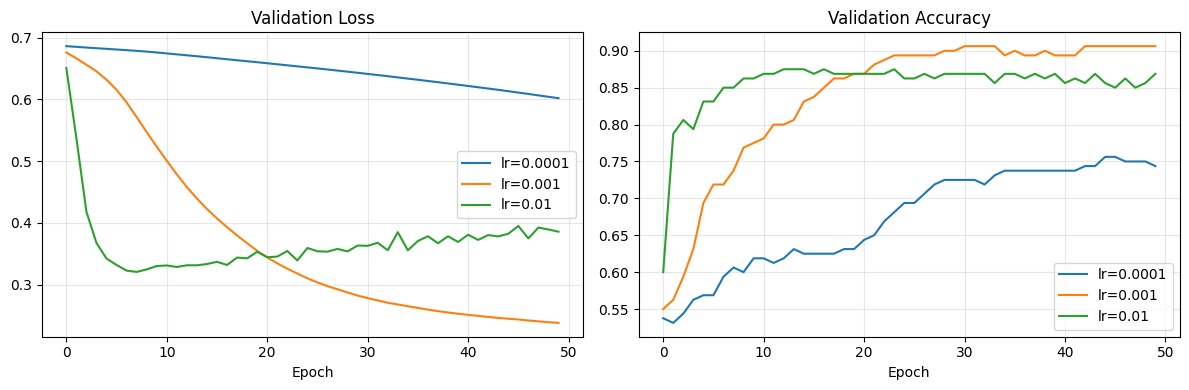

In [15]:
# Plot how different learning rates converge
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for lr in learning_rates:
    ax1.plot(histories[lr].history['val_loss'], label=f'lr={lr}')
    ax2.plot(histories[lr].history['val_accuracy'], label=f'lr={lr}')

ax1.set_title('Validation Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

You can really see the difference in the plots:
- **0.0001** - Super slow, barely converging within 50 epochs
- **0.001** - Nice smooth convergence, this is a solid default for Adam
- **0.01** - Converges fast but can be jumpy, might overshoot on harder problems

The 0.001 learning rate hits a good balance - 0.0001 is too slow and 0.01 can be unstable.

### Experiment 3: Does dropout help?

Dropout randomly turns off neurons during training to prevent overfitting. Testing with 30% dropout.

Dropout randomly "turns off" neurons during training to prevent overfitting. Let's see if it makes a difference here.

In [19]:
# Adding dropout after each hidden layer
def build_model_with_dropout(dropout_rate=0.3):
    model = keras.Sequential([
        keras.Input(shape=(10,)),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

model_dropout = build_model_with_dropout(0.3)
model_dropout.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Training with dropout...")
history_dropout = model_dropout.fit(X_train, y_train, epochs=50, batch_size=32,
                                     validation_split=0.2, verbose=0)

_, test_acc_dropout = model_dropout.evaluate(X_test, y_test, verbose=0)

print(f"\nWith dropout:    {test_acc_dropout*100:.2f}%")
print(f"Without dropout: {test_accuracy*100:.2f}%")

Training with dropout...

With dropout:    88.00%
Without dropout: 89.50%


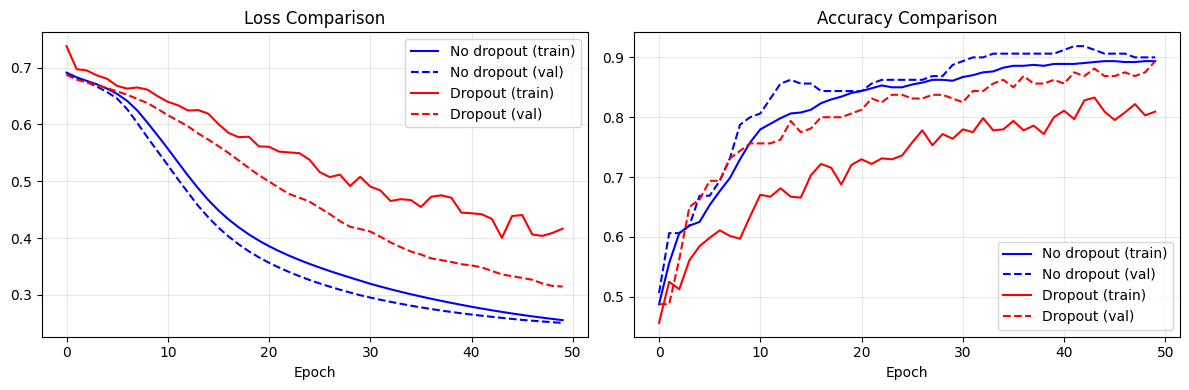

In [20]:
# Comparing the training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'], 'b-', label='No dropout (train)')
ax1.plot(history.history['val_loss'], 'b--', label='No dropout (val)')
ax1.plot(history_dropout.history['loss'], 'r-', label='Dropout (train)')
ax1.plot(history_dropout.history['val_loss'], 'r--', label='Dropout (val)')
ax1.set_title('Loss Comparison')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['accuracy'], 'b-', label='No dropout (train)')
ax2.plot(history.history['val_accuracy'], 'b--', label='No dropout (val)')
ax2.plot(history_dropout.history['accuracy'], 'r-', label='Dropout (train)')
ax2.plot(history_dropout.history['val_accuracy'], 'r--', label='Dropout (val)')
ax2.set_title('Accuracy Comparison')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

For this simple problem, dropout doesn't make much difference. The dataset is big enough and the network is small, so there's not much overfitting to prevent. Dropout would help more with bigger networks or less training data.

## Final Thoughts

Got the basics of building neural networks down. ReLU activations let the network learn non-linear patterns, learning rate of 0.001 works well for Adam, and dropout is useful but not always needed for simple problems. Good to see how the lecture concepts (backprop, gradient descent, etc.) work in practice!